## 8. EJERCICIO

Vamos a armar una pequeña competición en el curso.
El objetivo es armar una arquitectura de CNN que identifique el dataset MNIST.
Se van a usar capas de convolución, de activación y de pooling a elección. Cada alumno eligirá su modelo y los respectivos hiperparámetros, lo entrenará y presentará los siguientes resultados:

*   `test_acc` (del test final)
*   `n_parameter`
*   `n_layers` (conv + activacion + pooling = 1 capa)
*   `n_epochs` de entrenamiento usadas.


El modelo se deberá ajustar a los siguientes parámetros:

*   train: 80%, validation: 10%, test: 10% (los datos serán dados así todos usan el mismo set para cada grupo. Están en el github el curso).
*   capa final de salida será una softmax de 10 elementos.
*   coss_function será `CrossEntropyLoss`.

El ganador de la competencia será aquel que consiga el mayor `score` empleando la siguietne fórmula:

$$ score = \frac{1}{log_{10}(n\_parameter)} * \frac{10}{n\_epochs}*test\_acc*n\_layers$$

Deberan presentar su código colab funcionando y el score alcanzado (con los valores de cada variable que compone el score).

Es una competencia fairplay y con fines didácticos, esta formula del ```score``` fué inventada.... no usar como referencia para definir qué modelo utilizar.







#### Importar lo necesario

In [74]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torchsummary
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 7.8 MB/s 


#### configuramos el `device` acorde al device disponible




In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

1. Cargar base de datos

In [9]:
train = pickle.load( open( "/content/train.pkl", "rb" ) )
test = pickle.load( open( "/content/test.pkl", "rb" ) )
train_label = pickle.load( open( "/content/train_label.pkl", "rb" ) )
test_label = pickle.load( open( "/content/test_label.pkl", "rb" ) )
val = pickle.load( open( "/content/val.pkl", "rb" ) )
val_label = pickle.load( open( "/content/val_label.pkl", "rb" ) )


In [61]:
train = train.reshape(56000,1,28,28)
test = test.reshape(7000, 1,28,28)
val = val.reshape(7000,1, 28,28)

In [62]:
class YourDataset(Dataset):

    def __init__(self, X_Train, Y_Train, transform=None):
        self.X_Train = X_Train
        self.Y_Train = Y_Train
        self.transform = transform

    def __len__(self):
        return len(self.X_Train)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = self.X_Train[idx]
        y = self.Y_Train[idx]

        if self.transform:
            x = self.transform(x)
            y = self.transform(y)

        return x, y


In [63]:
train_dataset = YourDataset(train, train_label)
test_dataset = YourDataset(test, test_label)
val_dataset = YourDataset(val, val_label)

2. Ver que la base de datos esté OK

In [70]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


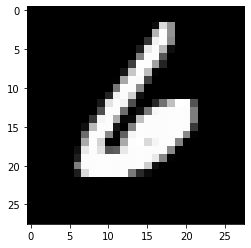

Label: 6


In [72]:
# Display image and label from dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(train_loader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = train_features[0].squeeze()
print('tamaño 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

3. Construyo mi CNN

In [73]:
class ConvModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=128, out_features=100)
        self.fc2 = torch.nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel()

if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]           4,640
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          18,496
         MaxPool2d-6             [-1, 64, 3, 3]               0
            Conv2d-7            [-1, 128, 3, 3]          73,856
         MaxPool2d-8            [-1, 128, 1, 1]               0
            Linear-9                  [-1, 100]          12,900
           Linear-10                   [-1, 10]           1,010
Total params: 111,062
Trainable params: 111,062
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 0.42
Estimated T

In [79]:
conv_model_optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)

conv_model_loss = torch.nn.CrossEntropyLoss()

conv_model_accuracy = torchmetrics.Accuracy()

if torch.cuda.is_available():
    conv_model_accuracy.to("cuda")

epochs = 20

train_loss = []
train_acc = []
valid_loss = []
valid_acc = []


for epoch in range(epochs):

    epoch_train_loss = 0.0
    epoch_train_accuracy = 0.0

    for train_data, train_target in train_loader:
        
        if torch.cuda.is_available():
            train_data = train_data.to("cuda")
            train_target = train_target.to("cuda")

        conv_model_optimizer.zero_grad()

        train_data = train_data.float()
    
        output = conv_model(train_data)
    
        loss = conv_model_loss(output, train_target)
        epoch_train_loss += loss.item()
        loss.backward()
    
        conv_model_optimizer.step()

        accuracy = conv_model_accuracy(output, train_target)
        epoch_train_accuracy += accuracy.item()

  
    epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_accuracy)

 
    epoch_valid_loss = 0.0
    epoch_valid_accuracy = 0.0

    for valid_data, valid_target in valid_loader:
        if torch.cuda.is_available():
            valid_data = valid_data.to("cuda")
            valid_target = valid_target.to("cuda")

        valid_data = valid_data.float()
 
        output = conv_model(valid_data)
        epoch_valid_loss += conv_model_loss(output, valid_target).item()
        epoch_valid_accuracy += conv_model_accuracy(output, valid_target).item()
      
    epoch_valid_loss = epoch_valid_loss / len(valid_loader)
    epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
    valid_loss.append(epoch_valid_loss)
    valid_acc.append(epoch_valid_accuracy)

    print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

Epoch: 1/20 - Train loss 0.062368 - Train Accuracy 0.981089 - Valid Loss 0.043384 - Valid Accuracy 0.986571
Epoch: 2/20 - Train loss 0.043969 - Train Accuracy 0.986946 - Valid Loss 0.040650 - Valid Accuracy 0.988571
Epoch: 3/20 - Train loss 0.033825 - Train Accuracy 0.989571 - Valid Loss 0.047982 - Valid Accuracy 0.987000
Epoch: 4/20 - Train loss 0.027807 - Train Accuracy 0.991179 - Valid Loss 0.048544 - Valid Accuracy 0.986286
Epoch: 5/20 - Train loss 0.025973 - Train Accuracy 0.992000 - Valid Loss 0.036297 - Valid Accuracy 0.990286
Epoch: 6/20 - Train loss 0.023037 - Train Accuracy 0.992839 - Valid Loss 0.046014 - Valid Accuracy 0.988571
Epoch: 7/20 - Train loss 0.019077 - Train Accuracy 0.993982 - Valid Loss 0.045144 - Valid Accuracy 0.988714
Epoch: 8/20 - Train loss 0.019659 - Train Accuracy 0.994232 - Valid Loss 0.038552 - Valid Accuracy 0.990857
Epoch: 9/20 - Train loss 0.016979 - Train Accuracy 0.994875 - Valid Loss 0.039853 - Valid Accuracy 0.990714
Epoch: 10/20 - Train loss 0.

In [81]:
test_loss = 0.0
test_accuracy = 0.0

for test_data, test_target in test_loader:
    if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()

    test_data = test_data.float()   
    output = conv_model(test_data)
    test_loss += conv_model_loss(output, test_target).item()
    test_accuracy += conv_model_accuracy(output, test_target).item()

test_loss = test_loss / len(test_loader)
test_accuracy = test_accuracy / len(test_loader)

print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logro un error de 0.056514 y una accuracy de 0.990571


torch.Size([1, 28, 28])
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)


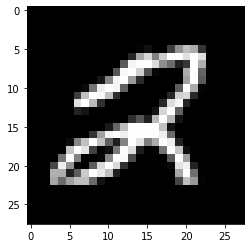

torch.Size([1, 1, 28, 28])
Predición del modelo:
tensor([[-19.0334,  -3.7215,  25.0505,  -9.0848,  -8.3753, -30.6435, -10.6920,
          -7.9584,  -6.8816, -24.1721]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
softmax de predicción:
tensor([[7.1544e-20, 3.1948e-13, 1.0000e+00, 1.4969e-15, 3.0433e-15, 6.4920e-25,
         3.0006e-16, 4.6175e-15, 1.3553e-14, 4.1966e-22]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
El numero es un:  2


In [89]:
# corremos 1 dato, a ver como lo clasifica...
# generamos un batch del dataloader
test_features, test_labels = next(iter(test_loader
                                       ))

# item a usar k
k = 50

# verifico las dimensiones y los valores que toma algun pixel.
samp_img = test_features[k]
print(samp_img.shape)
print(samp_img[0][0][0])
print(torch.max(samp_img))
print(torch.min(samp_img))
# ploteo la imagen
plt.imshow(samp_img.squeeze(), cmap='gray')
plt.show()

# preparo para pasarla a la red (model) asi predice.
samp_imp = samp_img.unsqueeze(0) # agrego la batch dim
samp_img = samp_img.unsqueeze(0).to(device)
samp_img = samp_img.float()
print(samp_img.shape)

# la paso al modelo
conv_model.eval()
y_hat = conv_model(samp_img)
print('Predición del modelo:')
print(y_hat)
print('softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1))
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())


# score final

In [85]:
test_acc = test_accuracy
n_params = 111.062
n_layers = 6
n_epochs = 20

score = 1/np.log(n_params) * 10/n_epochs * test_acc * n_layers
print('el Score final es:', score)

el Score final es: 0.6309253535731462
